# Traffic Forecasting — End-to-end Notebook

**Contains:** EDA, Feature Engineering, OOP data pipeline, Walk-forward CV, Models (RNN/LSTM/Customized/Seq2Seq), Transformer stub, Training utilities (AMP, schedulers, grad clipping, checkpoint), Optuna stub, Ensembling, Diagnostics.

**Data used:** uploaded file at `/content/data/Metro_Interstate_Traffic_Volume.csv`

**How to use:** run cells sequentially. Demo runs have small epochs; increase epochs for final experiments.


# **Set up thư viện**

In [1]:
# Imports and basic setup
import os, joblib, time
from dataclasses import dataclass
from typing import List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print('Torch version:', torch.__version__, 'CUDA available:', torch.cuda.is_available())

Torch version: 2.9.0+cu126 CUDA available: True


# **Cấu hình**

In [2]:
# Configuration
# DATA_PATH = '/mnt/data/Metro_Interstate_Traffic_Volume.csv'  # update if needed
DATA_PATH = '/content/Metro_Interstate_Traffic_Volume.csv'

@dataclass
class NBConfig:
    data_path: str = DATA_PATH
    pred_col: str = 'traffic_volume'
    lookback_options: List[int] = (24, 48, 168)
    horizon_task1: int = 2
    horizon_task2: int = 5
    features: Optional[List[str]] = None
    batch_size: int = 64
    models_dir: str = '/content/data/notebook_models'
    processed_dir: str = '/content/data/notebook_processed'
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed: int = 42

cfg = NBConfig()
os.makedirs(cfg.models_dir, exist_ok=True)
os.makedirs(cfg.processed_dir, exist_ok=True)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if cfg.device == 'cuda':
    torch.cuda.manual_seed_all(cfg.seed)
print(cfg)


NBConfig(data_path='/content/Metro_Interstate_Traffic_Volume.csv', pred_col='traffic_volume', lookback_options=(24, 48, 168), horizon_task1=2, horizon_task2=5, features=None, batch_size=64, models_dir='/content/data/notebook_models', processed_dir='/content/data/notebook_processed', device='cuda', seed=42)


# **Đọc và EDA cơ bản dataset**

Raw shape: (48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,4918


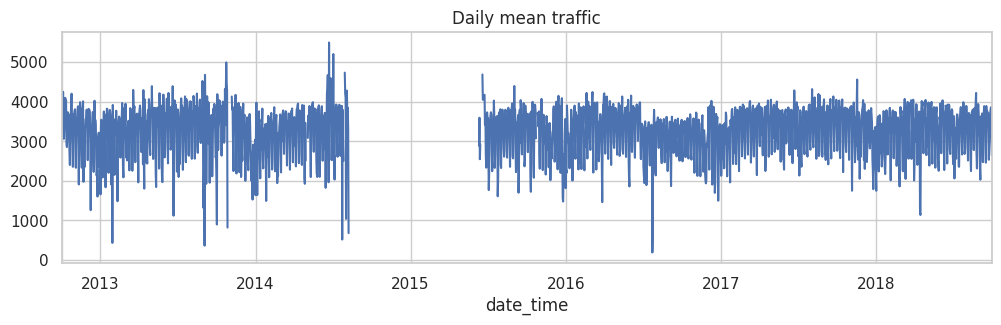

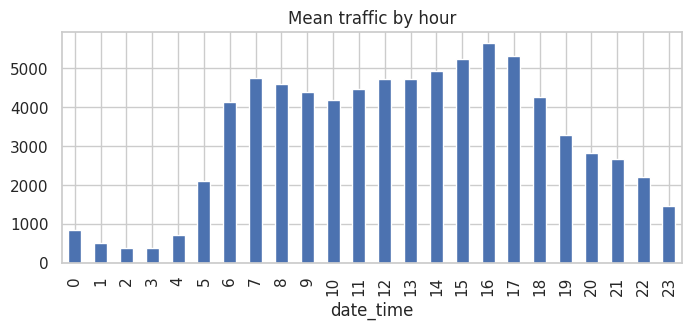

Missing values per column:\n holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
traffic_volume             0
dtype: int64


In [3]:
# Read data and basic EDA
df = pd.read_csv(cfg.data_path)
print('Raw shape:', df.shape)

df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time').set_index('date_time')
display(df.head())

# Basic plots
plt.figure(figsize=(12,3)); df['traffic_volume'].resample('D').mean().plot(); plt.title('Daily mean traffic'); plt.show()
plt.figure(figsize=(8,3)); (df.groupby(df.index.hour)['traffic_volume'].mean()).plot(kind='bar'); plt.title('Mean traffic by hour'); plt.show()

print('Missing values per column:\\n', df.isna().sum())

# **Feature Engineering**

In [4]:
# Feature engineering: lags, rolling, Fourier, categorical encoding, external regressors
def add_features(df, pred_col='traffic_volume'):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    # lags
    for l in [1,2,24,168]:
        df[f'lag_{l}'] = df[pred_col].shift(l)

    # rolling stats
    for w in [3,6,24,168]:
        df[f'roll_mean_{w}'] = df[pred_col].rolling(window=w, min_periods=1).mean()
        df[f'roll_median_{w}'] = df[pred_col].rolling(window=w, min_periods=1).median()
        df[f'roll_std_{w}'] = df[pred_col].rolling(window=w, min_periods=1).std().fillna(0)

    # Fourier seasonal terms
    hour_frac = df.index.hour + df.index.minute/60.0
    df['sin_24'] = np.sin(2*np.pi*hour_frac/24)
    df['cos_24'] = np.cos(2*np.pi*hour_frac/24)
    week_hour = df.index.dayofweek*24 + df.index.hour
    df['sin_168'] = np.sin(2*np.pi*week_hour/168)
    df['cos_168'] = np.cos(2*np.pi*week_hour/168)

    # weather_main one-hot (top categories)
    if 'weather_main' in df.columns:
        top_weather = df['weather_main'].value_counts().nlargest(8).index.tolist()
        for w in top_weather:
            df[f'weather_{w}'] = (df['weather_main'] == w).astype(int)

    # holiday flag
    if 'holiday' in df.columns:
        # Fill NaN in holiday column with 'None' before creating 'is_holiday'
        df['holiday'] = df['holiday'].fillna('None')
        df['is_holiday'] = (df['holiday'] != 'None').astype(int)

    return df

df_fe = add_features(df)
print('After FE shape:', df_fe.shape)

# Drop original categorical columns that are not used as features directly
# The 'exclude' list is defined in the next cell but we anticipate its content.
# These columns have been processed or will be ignored, but can cause dropna to remove too many rows.
if 'holiday' in df_fe.columns:
    df_fe = df_fe.drop(columns=['holiday'])
if 'weather_main' in df_fe.columns:
    df_fe = df_fe.drop(columns=['weather_main'])
if 'weather_description' in df_fe.columns:
    df_fe = df_fe.drop(columns=['weather_description'])

df_fe = df_fe.dropna().copy()   # remove initial rows lost by lags after handling other NaNs
print('After dropna shape:', df_fe.shape)

After FE shape: (48204, 40)
After dropna shape: (48036, 37)


# **Build feature list & walk-forward splits**

In [5]:
# Auto-select numeric features (exclude textual raw columns)
exclude = ['weather_main','weather_description','holiday']
numeric_cols = df_fe.select_dtypes(include='number').columns.tolist()
features = [c for c in numeric_cols if c not in exclude]
print('Feature count:', len(features))
print('Sample features:', features[:30])

# Walk-forward splits generator
def walk_forward_splits(index, n_splits=4, train_ratio=0.6, val_ratio=0.2):
    n = len(index)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    step = max(1, int((n - train_size - val_size) / n_splits))
    splits = []
    for i in range(n_splits):
        train_end = train_size + i*step
        val_start = train_end
        val_end = val_start + val_size
        test_start = val_end
        test_end = min(test_start + val_size, n)
        splits.append((train_end, val_start, val_end, test_start, test_end))
    return splits

splits = walk_forward_splits(df_fe.index, n_splits=4)
print('Example splits (train_end, val_start, val_end, test_start, test_end):')
for s in splits: print(s)

Feature count: 37
Sample features: ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'dayofweek', 'month', 'lag_1', 'lag_2', 'lag_24', 'lag_168', 'roll_mean_3', 'roll_median_3', 'roll_std_3', 'roll_mean_6', 'roll_median_6', 'roll_std_6', 'roll_mean_24', 'roll_median_24', 'roll_std_24', 'roll_mean_168', 'roll_median_168', 'roll_std_168', 'sin_24', 'cos_24', 'sin_168', 'cos_168', 'weather_Clouds', 'weather_Clear']
Example splits (train_end, val_start, val_end, test_start, test_end):
(28821, 28821, 38428, 38428, 48035)
(31223, 31223, 40830, 40830, 48036)
(33625, 33625, 43232, 43232, 48036)
(36027, 36027, 45634, 45634, 48036)


In [6]:
from sklearn.preprocessing import MinMaxScaler

def build_scaled_data(df, features, split, scaler_cls=MinMaxScaler):
    train_end, val_start, val_end, test_start, test_end = split
    train_df = df.iloc[:train_end]
    val_df = df.iloc[val_start:val_end]
    test_df = df.iloc[test_start:test_end]
    scaler = scaler_cls()
    scaler.fit(train_df[features])
    train_s = pd.DataFrame(scaler.transform(train_df[features]), index=train_df.index, columns=features)
    val_s = pd.DataFrame(scaler.transform(val_df[features]), index=val_df.index, columns=features)
    test_s = pd.DataFrame(scaler.transform(test_df[features]), index=test_df.index, columns=features)
    return train_s, val_s, test_s, scaler

train_s, val_s, test_s, scaler0 = build_scaled_data(df_fe, features, splits[0])
print('Train/Val/Test shapes:', train_s.shape, val_s.shape, test_s.shape)
joblib.dump(scaler0, os.path.join(cfg.processed_dir, 'scaler_split0.save'))

Train/Val/Test shapes: (28821, 37) (9607, 37) (9607, 37)


['/content/data/notebook_processed/scaler_split0.save']

# **Mô hình**

In [7]:
# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, df, features, lookback, horizon, pred_col):
        self.X = df[features].values.astype(np.float32)
        self.lookback = lookback
        self.horizon = horizon
        self.pred_idx = features.index(pred_col)
        self.length = len(self.X) - lookback - horizon + 1
    def __len__(self): return max(0, self.length)
    def __getitem__(self, idx):
        s = idx
        x = self.X[s:s+self.lookback]
        y = self.X[s+self.lookback:s+self.lookback+self.horizon, self.pred_idx]
        return torch.from_numpy(x), torch.from_numpy(y)

# Simple models and Customized LSTM + Seq2Seq (see comments)
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, horizon=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.head(out[:, -1, :])

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden=64, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :])

class CustomizedLSTM(nn.Module):
    def __init__(self, input_dim, hidden=128, num_layers=1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=num_layers, batch_first=True)
        self.attn = nn.Linear(hidden, 1)
        self.res_fc = nn.Linear(input_dim, hidden)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, horizon))
        self.apply(init_weights)
    def forward(self, x):
        out, _ = self.lstm(x)
        scores = torch.softmax(self.attn(out).squeeze(-1), dim=1).unsqueeze(-1)
        context = (out * scores).sum(dim=1)
        residual = self.res_fc(x[:, -1, :])
        return self.head(context + residual)

# Seq2Seq with attention + teacher forcing
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
    def forward(self, x):
        out, (h,c) = self.lstm(x)
        return out, (h,c)

class Attention(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.fc = nn.Linear(hidden*2, hidden)
        self.v = nn.Linear(hidden, 1, bias=False)
    def forward(self, hidden, enc_out):
        seq = enc_out.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, seq, 1)
        e = torch.tanh(self.fc(torch.cat((hidden, enc_out), dim=2)))
        s = self.v(e).squeeze(2)
        w = torch.softmax(s, dim=1)
        ctx = torch.bmm(w.unsqueeze(1), enc_out).squeeze(1)
        return ctx, w

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden):
        super().__init__()
        self.cell = nn.LSTMCell(input_dim, hidden)
        self.att = Attention(hidden)
        self.out = nn.Linear(hidden, 1)
    def forward(self, enc_out, h, c, tgt_len, teacher_forcing_ratio=0.5, targets=None):
        batch = enc_out.size(0); device = enc_out.device
        inp = torch.zeros(batch, 1, device=device)
        h = h.squeeze(0); c = c.squeeze(0)
        outs = []
        for t in range(tgt_len):
            ctx, _ = self.att(h, enc_out)
            rnn_in = torch.cat((inp, ctx), dim=1)
            h, c = self.cell(rnn_in, (h, c))
            o = self.out(h)
            outs.append(o)
            if targets is not None and (torch.rand(1).item() < teacher_forcing_ratio):
                inp = targets[:, t].unsqueeze(1).to(device)
            else:
                inp = o
        outs = torch.stack(outs, dim=1).squeeze(-1)
        return outs

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, enc_hidden=128, dec_hidden=128):
        super().__init__()
        self.enc = Encoder(input_dim, enc_hidden)
        self.dec = Decoder(1 + enc_hidden, dec_hidden)
    def forward(self, x, tgt_len, teacher_forcing_ratio=0.5, targets=None):
        enc_out, (h,c) = self.enc(x)
        return self.dec(enc_out, h, c, tgt_len, teacher_forcing_ratio, targets)

# **Training Utility**

In [8]:
from tqdm.auto import tqdm

def train_loop(model, train_loader, val_loader, cfg, scaler, task=1, horizon=1, epochs=10, lr=1e-3,
               grad_clip=1.0, use_amp=True, scheduler=None, save_path=None, teacher_schedule=None):
    device = torch.device(cfg.device)
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
    best_val = float('inf'); best_state = None
    for ep in range(1, epochs+1):
        model.train(); losses = []
        tf_ratio = 0.0
        if teacher_schedule is not None:
            tf_ratio = teacher_schedule(ep)
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):
                if task == 1:
                    pred = model(xb)
                else:
                    pred = model(xb, horizon, teacher_forcing_ratio=tf_ratio, targets=yb)
                loss = nn.MSELoss()(pred, yb)
            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            scaler_amp.step(opt); scaler_amp.update()
            losses.append(float(loss.detach().cpu().numpy()))
        # validation
        model.eval(); val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                if task == 1:
                    pred = model(xb)
                else:
                    pred = model(xb, horizon, teacher_forcing_ratio=0.0, targets=None)
                val_losses.append(float(nn.MSELoss()(pred, yb).cpu().numpy()))
        tr_loss = np.mean(losses); val_loss = np.mean(val_losses)
        if scheduler is not None:
            try:
                scheduler.step(val_loss)
            except:
                scheduler.step()
        if val_loss < best_val:
            best_val = val_loss; best_state = model.state_dict()
            if save_path is not None:
                torch.save(best_state, save_path)
        if ep % max(1, epochs//5) == 0 or ep == 1:
            print(f'Epoch {ep}/{epochs} train={tr_loss:.6f} val={val_loss:.6f} tf_ratio={tf_ratio:.3f}')
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# evaluate helpers (inverse scale)
def inv_scale(y_scaled, scaler, features, pred_col):
    n, h = y_scaled.shape
    mats = np.zeros((n, len(features)))
    outs = []
    for i in range(h):
        mats[:, features.index(pred_col)] = y_scaled[:, i]
        outs.append(scaler.inverse_transform(mats)[:, features.index(pred_col)])
    return np.stack(outs, axis=1)

def evaluate_model(model, loader, cfg, scaler, features, horizon=1, task=1):
    device = torch.device(cfg.device); model = model.to(device); model.eval()
    Ys = []; Ps = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            if task == 1:
                p = model(xb).cpu().numpy()
            else:
                p = model(xb, horizon, teacher_forcing_ratio=0.0, targets=None).cpu().numpy()
            Ys.append(yb.numpy()); Ps.append(p)
    Y = np.vstack(Ys); P = np.vstack(Ps)
    Y_inv = inv_scale(Y, scaler, features, cfg.pred_col)
    P_inv = inv_scale(P, scaler, features, cfg.pred_col)
    rows = []
    for i in range(horizon):
        yt = Y_inv[:, i]; yp = P_inv[:, i]
        mae = mean_absolute_error(yt, yp); rmse = np.sqrt(mean_squared_error(yt, yp)) #np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp); denom = np.sum((yt - np.mean(yt))**2)
        nse = 1 - np.sum((yt - yp)**2) / denom if denom != 0 else np.nan
        rows.append({'horizon': i+1, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'NSE': nse})
    return pd.DataFrame(rows), Y_inv, P_inv

# **Demo training (small epochs) + scheduled teacher forcing**

In [9]:
# Demo: prepare loaders for first split and lookback 48
LOOKBACK = 48
train_s, val_s, test_s, scaler0 = build_scaled_data(df_fe, features, splits[0])
tr = DataLoader(TimeSeriesDataset(train_s, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size, shuffle=True)
va = DataLoader(TimeSeriesDataset(val_s, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size, shuffle=False)
te = DataLoader(TimeSeriesDataset(test_s, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size, shuffle=False)

# instantiate and train
model_lstm = SimpleLSTM(len(features), hidden=128, num_layers=1, horizon=cfg.horizon_task1)
model_seq = Seq2Seq(len(features), enc_hidden=128, dec_hidden=128)

def teacher_schedule(ep):
    if ep <= 3: return 0.9
    if ep <= 6: return 0.6
    return 0.0

model_lstm = train_loop(model_lstm, tr, va, cfg, scaler0, task=1, horizon=cfg.horizon_task1, epochs=6, lr=1e-3, use_amp=False, save_path=os.path.join(cfg.models_dir,'lstm_demo.pth'))
model_seq = train_loop(model_seq, tr, va, cfg, scaler0, task=2, horizon=cfg.horizon_task1, epochs=6, lr=1e-3, use_amp=False, save_path=os.path.join(cfg.models_dir,'seq_demo.pth'), teacher_schedule=teacher_schedule)

met_lstm, Y_lstm, P_lstm = evaluate_model(model_lstm, te, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)
met_seq, Y_seq, P_seq = evaluate_model(model_seq, te, cfg, scaler0, features, horizon=cfg.horizon_task1, task=2)
print('LSTM metrics:\\n', met_lstm)
print('Seq2Seq metrics:\\n', met_seq)

/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/6 train=0.018670 val=0.007877 tf_ratio=0.000
Epoch 2/6 train=0.009706 val=0.006098 tf_ratio=0.000
Epoch 3/6 train=0.008112 val=0.004963 tf_ratio=0.000
Epoch 4/6 train=0.007163 val=0.005448 tf_ratio=0.000
Epoch 5/6 train=0.006602 val=0.004741 tf_ratio=0.000
Epoch 6/6 train=0.006366 val=0.005234 tf_ratio=0.000
Epoch 1/6 train=0.018102 val=0.009596 tf_ratio=0.900
Epoch 2/6 train=0.007855 val=0.006617 tf_ratio=0.900
Epoch 3/6 train=0.006912 val=0.005751 tf_ratio=0.900
Epoch 4/6 train=0.006881 val=0.005616 tf_ratio=0.600
Epoch 5/6 train=0.006526 val=0.005631 tf_ratio=0.600
Epoch 6/6 train=0.006119 val=0.005373 tf_ratio=0.600
LSTM metrics:\n    horizon         MAE        RMSE        R2       NSE
0        1  326.758644  443.202073  0.949209  0.949209
1        2  411.849669  568.981362  0.916296  0.916296
Seq2Seq metrics:\n    horizon         MAE        RMSE        R2       NSE
0        1  300.838834  415.365027  0.955388  0.955388
1        2  408.074932  560.057848  0.918901  0.918901

                 mean         std
date_time                        
0         -250.800659  394.247493
1         -373.654151  223.859523
2         -286.139119  137.770980
3         -284.174383  158.445443
4         -367.576581  311.367008
5         -530.220150  597.330878
6         -422.546482  692.459387
7         -300.963626  485.422503
8         -304.224364  464.898277
9         -244.528228  404.100353
10        -176.307465  320.796809
11        -223.303516  240.109665
12         -13.687245  223.350832
13         -54.278991  248.080180
14        -248.375610  249.062553
15        -246.230604  256.195492
16        -101.356237  327.409472
17         148.269448  361.884152
18          -3.329049  441.797569
19         -20.471397  385.165906
20        -131.040039  266.487765
21         -26.814249  239.459834
22          26.766659  334.078845
23         -78.945809  411.627882


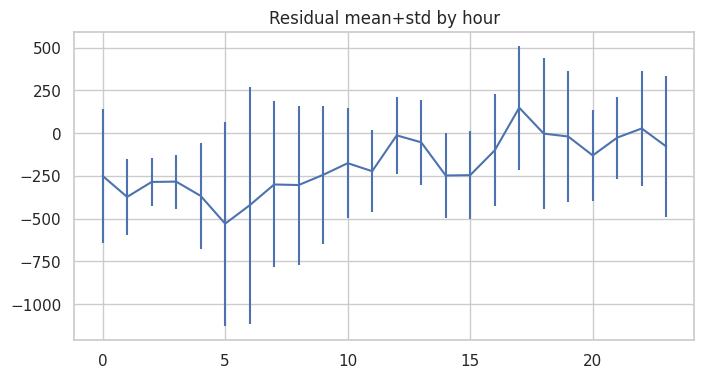

Base RMSE (small): 523.664151693669
Top permutation importances (approx):
traffic_volume    1964.951144
roll_mean_3        165.486660
roll_median_3       80.985087
dayofweek           74.330174
roll_std_6          51.117089
roll_std_3          50.184645
roll_mean_6         36.287151
lag_1               28.037937
roll_median_6       25.115015
lag_24              10.722502
roll_mean_24         8.568844
roll_median_24       2.321060
temp                 2.155799
month                0.844747
clouds_all           0.723237
dtype: float64


In [10]:
# Residuals by hour (LSTM example)
Yinv, Pinv = Y_lstm, P_lstm
res = Yinv[:,0] - Pinv[:,0]
# align to test index
test_idx = test_s.index[LOOKBACK+cfg.horizon_task1-1:LOOKBACK+cfg.horizon_task1-1+len(res)]
ser = pd.Series(res, index=test_idx)
grp = ser.groupby(ser.index.hour).agg(['mean','std'])
print(grp)
plt.figure(figsize=(8,4)); plt.errorbar(grp.index, grp['mean'], yerr=grp['std']); plt.title('Residual mean+std by hour'); plt.show()

# Permutation importance on small subset (expensive) - approximate
from sklearn.metrics import mean_squared_error
small_test = test_s.iloc[:2000]
base_loader = DataLoader(TimeSeriesDataset(small_test, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size)
base_rmse = evaluate_model(model_lstm, base_loader, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)[0]['RMSE'].mean()
print('Base RMSE (small):', base_rmse)
importances = {}
for f in features[:20]:
    vals = []
    for _ in range(2):
        Xp = small_test.copy(); Xp[f] = np.random.permutation(Xp[f].values)
        loader = DataLoader(TimeSeriesDataset(Xp, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size)
        rm = evaluate_model(model_lstm, loader, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)[0]['RMSE'].mean()
        vals.append(rm - base_rmse)
    importances[f] = np.mean(vals)
imp_series = pd.Series(importances).sort_values(ascending=False)
print('Top permutation importances (approx):'); print(imp_series.head(15))

                 mean         std
date_time                        
0         -250.800659  394.247493
1         -373.654151  223.859523
2         -286.139119  137.770980
3         -284.174383  158.445443
4         -367.576581  311.367008
5         -530.220150  597.330878
6         -422.546482  692.459387
7         -300.963626  485.422503
8         -304.224364  464.898277
9         -244.528228  404.100353
10        -176.307465  320.796809
11        -223.303516  240.109665
12         -13.687245  223.350832
13         -54.278991  248.080180
14        -248.375610  249.062553
15        -246.230604  256.195492
16        -101.356237  327.409472
17         148.269448  361.884152
18          -3.329049  441.797569
19         -20.471397  385.165906
20        -131.040039  266.487765
21         -26.814249  239.459834
22          26.766659  334.078845
23         -78.945809  411.627882


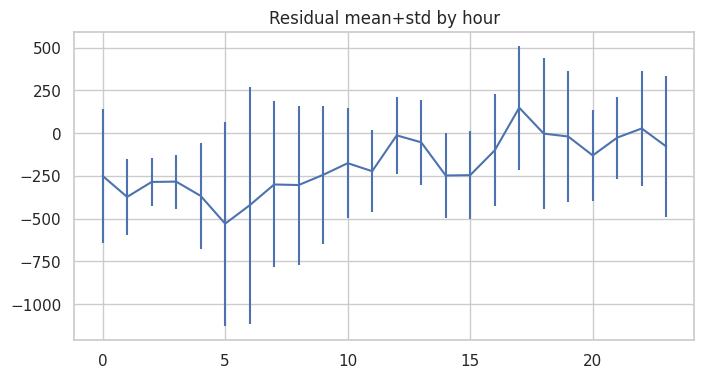

Base RMSE (small): 523.664151693669
Top permutation importances (approx):
traffic_volume    1991.959841
roll_mean_3        158.378522
roll_median_3       76.029741
dayofweek           70.931201
roll_std_6          53.566105
roll_std_3          38.624852
roll_mean_6         34.798079
lag_1               27.627870
roll_median_6       26.063121
roll_mean_24        11.558656
lag_24              10.135731
roll_median_24       3.139633
temp                 2.083459
month                1.167175
clouds_all           0.677450
dtype: float64


In [11]:
# Residuals by hour (LSTM example)
Yinv, Pinv = Y_lstm, P_lstm
res = Yinv[:,0] - Pinv[:,0]

# align to test index
test_idx = test_s.index[LOOKBACK+cfg.horizon_task1-1:LOOKBACK+cfg.horizon_task1-1+len(res)]
ser = pd.Series(res, index=test_idx)
grp = ser.groupby(ser.index.hour).agg(['mean','std'])
print(grp)
plt.figure(figsize=(8,4)); plt.errorbar(grp.index, grp['mean'], yerr=grp['std']); plt.title('Residual mean+std by hour'); plt.show()

# Permutation importance on small subset (expensive) - approximate
from sklearn.metrics import mean_squared_error
small_test = test_s.iloc[:2000]
base_loader = DataLoader(TimeSeriesDataset(small_test, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size)
base_rmse = evaluate_model(model_lstm, base_loader, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)[0]['RMSE'].mean()
print('Base RMSE (small):', base_rmse)
importances = {}
for f in features[:20]:
    vals = []
    for _ in range(2):
        Xp = small_test.copy(); Xp[f] = np.random.permutation(Xp[f].values)
        loader = DataLoader(TimeSeriesDataset(Xp, features, LOOKBACK, cfg.horizon_task1, cfg.pred_col), batch_size=cfg.batch_size)
        rm = evaluate_model(model_lstm, loader, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)[0]['RMSE'].mean()
        vals.append(rm - base_rmse)
    importances[f] = np.mean(vals)
imp_series = pd.Series(importances).sort_values(ascending=False)
print('Top permutation importances (approx):'); print(imp_series.head(15))

In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.8 MB/s eta 0:00:00


In [13]:
# Optuna stub (install optuna if needed)
try:
    import optuna
except Exception as e:
    print('Optuna not installed. Install with: pip install optuna')

# Pseudo-objective:
def objective(trial):
    hidden = trial.suggest_int('hidden', 64, 256)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    model = SimpleLSTM(len(features), hidden=hidden, num_layers=1, horizon=cfg.horizon_task1)
    model = train_loop(model, tr, va, cfg, scaler0, task=1, horizon=cfg.horizon_task1, epochs=8, lr=lr)
    val_rmse = evaluate_model(model, va, cfg, scaler0, features, horizon=cfg.horizon_task1, task=1)[0]['RMSE'].mean()
    return val_rmse

study = optuna.create_study(direction='minimize'); study.optimize(objective, n_trials=20)
print('Optuna stub ready — adapt and run on your machine.')

# Transformer/TCN/TemporalFusionTransformer/N-BEATS: consider using pytorch-forecasting or implement a lightweight Transformer encoder-decoder.

[I 2025-11-24 07:28:56,515] A new study created in memory with name: no-name-740c55b6-0e54-4093-9d0c-95bacfb34915
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.015725 val=0.007102 tf_ratio=0.000
Epoch 2/8 train=0.008683 val=0.005503 tf_ratio=0.000
Epoch 3/8 train=0.007375 val=0.004822 tf_ratio=0.000
Epoch 4/8 train=0.006620 val=0.004838 tf_ratio=0.000
Epoch 5/8 train=0.006264 val=0.005768 tf_ratio=0.000
Epoch 6/8 train=0.006068 val=0.004104 tf_ratio=0.000
Epoch 7/8 train=0.005813 val=0.004117 tf_ratio=0.000
Epoch 8/8 train=0.005661 val=0.003922 tf_ratio=0.000


[I 2025-11-24 07:29:20,147] Trial 0 finished with value: 450.01509837626315 and parameters: {'hidden': 243, 'lr': 0.0007771206300862178}. Best is trial 0 with value: 450.01509837626315.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.027708 val=0.012196 tf_ratio=0.000
Epoch 2/8 train=0.012950 val=0.009029 tf_ratio=0.000
Epoch 3/8 train=0.010915 val=0.007748 tf_ratio=0.000
Epoch 4/8 train=0.009735 val=0.006736 tf_ratio=0.000
Epoch 5/8 train=0.008954 val=0.006585 tf_ratio=0.000
Epoch 6/8 train=0.008356 val=0.005691 tf_ratio=0.000
Epoch 7/8 train=0.007995 val=0.005817 tf_ratio=0.000
Epoch 8/8 train=0.007506 val=0.005190 tf_ratio=0.000


[I 2025-11-24 07:29:44,581] Trial 1 finished with value: 517.8592428740485 and parameters: {'hidden': 244, 'lr': 0.00010289427780099062}. Best is trial 0 with value: 450.01509837626315.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.016603 val=0.007885 tf_ratio=0.000
Epoch 2/8 train=0.008833 val=0.005743 tf_ratio=0.000
Epoch 3/8 train=0.007684 val=0.005169 tf_ratio=0.000
Epoch 4/8 train=0.006975 val=0.004545 tf_ratio=0.000
Epoch 5/8 train=0.006553 val=0.005037 tf_ratio=0.000
Epoch 6/8 train=0.006261 val=0.004202 tf_ratio=0.000
Epoch 7/8 train=0.006011 val=0.004308 tf_ratio=0.000
Epoch 8/8 train=0.005849 val=0.003875 tf_ratio=0.000


[I 2025-11-24 07:30:09,536] Trial 2 finished with value: 447.54485520339017 and parameters: {'hidden': 160, 'lr': 0.001002049129049423}. Best is trial 2 with value: 447.54485520339017.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.043483 val=0.005920 tf_ratio=0.000
Epoch 2/8 train=0.008230 val=0.004939 tf_ratio=0.000
Epoch 3/8 train=0.007103 val=0.004451 tf_ratio=0.000
Epoch 4/8 train=0.006643 val=0.004808 tf_ratio=0.000
Epoch 5/8 train=0.006402 val=0.005235 tf_ratio=0.000
Epoch 6/8 train=0.006166 val=0.004670 tf_ratio=0.000
Epoch 7/8 train=0.006075 val=0.004547 tf_ratio=0.000
Epoch 8/8 train=0.005810 val=0.004670 tf_ratio=0.000


[I 2025-11-24 07:30:32,879] Trial 3 finished with value: 495.1783514034614 and parameters: {'hidden': 248, 'lr': 0.007912813155977126}. Best is trial 2 with value: 447.54485520339017.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.031742 val=0.014043 tf_ratio=0.000
Epoch 2/8 train=0.014389 val=0.009888 tf_ratio=0.000
Epoch 3/8 train=0.012002 val=0.009372 tf_ratio=0.000
Epoch 4/8 train=0.010872 val=0.007992 tf_ratio=0.000
Epoch 5/8 train=0.009857 val=0.007053 tf_ratio=0.000
Epoch 6/8 train=0.009254 val=0.006393 tf_ratio=0.000
Epoch 7/8 train=0.008661 val=0.006069 tf_ratio=0.000
Epoch 8/8 train=0.008217 val=0.005636 tf_ratio=0.000


[I 2025-11-24 07:30:56,105] Trial 4 finished with value: 537.9020294665133 and parameters: {'hidden': 210, 'lr': 0.00010976224540101556}. Best is trial 2 with value: 447.54485520339017.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.029080 val=0.010964 tf_ratio=0.000
Epoch 2/8 train=0.011905 val=0.008049 tf_ratio=0.000
Epoch 3/8 train=0.009890 val=0.006796 tf_ratio=0.000
Epoch 4/8 train=0.008767 val=0.006180 tf_ratio=0.000
Epoch 5/8 train=0.007961 val=0.005251 tf_ratio=0.000
Epoch 6/8 train=0.007347 val=0.004988 tf_ratio=0.000
Epoch 7/8 train=0.007018 val=0.004789 tf_ratio=0.000
Epoch 8/8 train=0.006745 val=0.004480 tf_ratio=0.000


[I 2025-11-24 07:31:14,169] Trial 5 finished with value: 481.13971418585334 and parameters: {'hidden': 77, 'lr': 0.0005250050714842297}. Best is trial 2 with value: 447.54485520339017.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.015985 val=0.006536 tf_ratio=0.000
Epoch 2/8 train=0.008458 val=0.005664 tf_ratio=0.000
Epoch 3/8 train=0.007298 val=0.004482 tf_ratio=0.000
Epoch 4/8 train=0.006614 val=0.004271 tf_ratio=0.000
Epoch 5/8 train=0.006318 val=0.003887 tf_ratio=0.000
Epoch 6/8 train=0.006126 val=0.004367 tf_ratio=0.000
Epoch 7/8 train=0.005862 val=0.004260 tf_ratio=0.000
Epoch 8/8 train=0.005625 val=0.003693 tf_ratio=0.000


[I 2025-11-24 07:31:58,638] Trial 6 finished with value: 438.4236082641895 and parameters: {'hidden': 182, 'lr': 0.0016636116254243342}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.023411 val=0.010932 tf_ratio=0.000
Epoch 2/8 train=0.011536 val=0.007721 tf_ratio=0.000
Epoch 3/8 train=0.009756 val=0.006818 tf_ratio=0.000
Epoch 4/8 train=0.008673 val=0.006104 tf_ratio=0.000
Epoch 5/8 train=0.007817 val=0.005587 tf_ratio=0.000
Epoch 6/8 train=0.007290 val=0.005571 tf_ratio=0.000
Epoch 7/8 train=0.006935 val=0.004610 tf_ratio=0.000
Epoch 8/8 train=0.006731 val=0.004465 tf_ratio=0.000


[I 2025-11-24 07:32:21,473] Trial 7 finished with value: 480.03253482905745 and parameters: {'hidden': 196, 'lr': 0.0001956991706976717}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.045786 val=0.018387 tf_ratio=0.000
Epoch 2/8 train=0.017864 val=0.012643 tf_ratio=0.000
Epoch 3/8 train=0.013958 val=0.010420 tf_ratio=0.000
Epoch 4/8 train=0.012402 val=0.009348 tf_ratio=0.000
Epoch 5/8 train=0.011424 val=0.009442 tf_ratio=0.000
Epoch 6/8 train=0.010773 val=0.008711 tf_ratio=0.000
Epoch 7/8 train=0.010142 val=0.007336 tf_ratio=0.000
Epoch 8/8 train=0.009560 val=0.006929 tf_ratio=0.000


[I 2025-11-24 07:32:39,475] Trial 8 finished with value: 596.3168436953931 and parameters: {'hidden': 75, 'lr': 0.00011497228165506247}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.014553 val=0.007352 tf_ratio=0.000
Epoch 2/8 train=0.008329 val=0.005293 tf_ratio=0.000
Epoch 3/8 train=0.007232 val=0.004494 tf_ratio=0.000
Epoch 4/8 train=0.006748 val=0.004681 tf_ratio=0.000
Epoch 5/8 train=0.006202 val=0.004138 tf_ratio=0.000
Epoch 6/8 train=0.005977 val=0.004072 tf_ratio=0.000
Epoch 7/8 train=0.005845 val=0.004625 tf_ratio=0.000
Epoch 8/8 train=0.005711 val=0.004072 tf_ratio=0.000


[I 2025-11-24 07:33:05,765] Trial 9 finished with value: 461.0553773241476 and parameters: {'hidden': 135, 'lr': 0.002050139879904253}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.015304 val=0.006646 tf_ratio=0.000
Epoch 2/8 train=0.008472 val=0.005193 tf_ratio=0.000
Epoch 3/8 train=0.007240 val=0.005402 tf_ratio=0.000
Epoch 4/8 train=0.006684 val=0.004897 tf_ratio=0.000
Epoch 5/8 train=0.006386 val=0.004143 tf_ratio=0.000
Epoch 6/8 train=0.006193 val=0.004929 tf_ratio=0.000
Epoch 7/8 train=0.005926 val=0.003957 tf_ratio=0.000
Epoch 8/8 train=0.005841 val=0.004236 tf_ratio=0.000


[I 2025-11-24 07:33:23,145] Trial 10 finished with value: 468.22134845050846 and parameters: {'hidden': 120, 'lr': 0.005094261826083691}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.014733 val=0.006999 tf_ratio=0.000
Epoch 2/8 train=0.008605 val=0.005589 tf_ratio=0.000
Epoch 3/8 train=0.007413 val=0.004515 tf_ratio=0.000
Epoch 4/8 train=0.006656 val=0.004499 tf_ratio=0.000
Epoch 5/8 train=0.006280 val=0.004292 tf_ratio=0.000
Epoch 6/8 train=0.005991 val=0.004409 tf_ratio=0.000
Epoch 7/8 train=0.005917 val=0.004399 tf_ratio=0.000
Epoch 8/8 train=0.005652 val=0.003845 tf_ratio=0.000


[I 2025-11-24 07:34:04,851] Trial 11 finished with value: 446.49351826972065 and parameters: {'hidden': 170, 'lr': 0.0020721453301222447}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.014885 val=0.006869 tf_ratio=0.000
Epoch 2/8 train=0.008384 val=0.005323 tf_ratio=0.000
Epoch 3/8 train=0.007253 val=0.004334 tf_ratio=0.000
Epoch 4/8 train=0.006676 val=0.004641 tf_ratio=0.000
Epoch 5/8 train=0.006276 val=0.005279 tf_ratio=0.000
Epoch 6/8 train=0.005957 val=0.004103 tf_ratio=0.000
Epoch 7/8 train=0.005816 val=0.004652 tf_ratio=0.000
Epoch 8/8 train=0.005721 val=0.004002 tf_ratio=0.000


[I 2025-11-24 07:34:49,906] Trial 12 finished with value: 454.5015074437496 and parameters: {'hidden': 187, 'lr': 0.00248204921496608}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.017174 val=0.007328 tf_ratio=0.000
Epoch 2/8 train=0.008610 val=0.005037 tf_ratio=0.000
Epoch 3/8 train=0.007288 val=0.004969 tf_ratio=0.000
Epoch 4/8 train=0.006706 val=0.004273 tf_ratio=0.000
Epoch 5/8 train=0.006353 val=0.004723 tf_ratio=0.000
Epoch 6/8 train=0.006015 val=0.004187 tf_ratio=0.000
Epoch 7/8 train=0.005855 val=0.004731 tf_ratio=0.000
Epoch 8/8 train=0.005745 val=0.004200 tf_ratio=0.000


[I 2025-11-24 07:35:30,321] Trial 13 finished with value: 465.13057493344854 and parameters: {'hidden': 162, 'lr': 0.0019114302053832284}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.014393 val=0.007288 tf_ratio=0.000
Epoch 2/8 train=0.008576 val=0.006366 tf_ratio=0.000
Epoch 3/8 train=0.007304 val=0.004608 tf_ratio=0.000
Epoch 4/8 train=0.006665 val=0.004976 tf_ratio=0.000
Epoch 5/8 train=0.006499 val=0.004535 tf_ratio=0.000
Epoch 6/8 train=0.006127 val=0.003872 tf_ratio=0.000
Epoch 7/8 train=0.005802 val=0.003719 tf_ratio=0.000
Epoch 8/8 train=0.005729 val=0.004132 tf_ratio=0.000


[I 2025-11-24 07:36:10,605] Trial 14 finished with value: 463.92370653627194 and parameters: {'hidden': 164, 'lr': 0.003944019164410913}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.025066 val=0.010254 tf_ratio=0.000
Epoch 2/8 train=0.011020 val=0.007639 tf_ratio=0.000
Epoch 3/8 train=0.009213 val=0.006776 tf_ratio=0.000
Epoch 4/8 train=0.008187 val=0.005566 tf_ratio=0.000
Epoch 5/8 train=0.007587 val=0.005054 tf_ratio=0.000
Epoch 6/8 train=0.007158 val=0.004580 tf_ratio=0.000
Epoch 7/8 train=0.006799 val=0.005409 tf_ratio=0.000
Epoch 8/8 train=0.006612 val=0.004698 tf_ratio=0.000


[I 2025-11-24 07:36:28,841] Trial 15 finished with value: 492.49303568101084 and parameters: {'hidden': 119, 'lr': 0.0004186362833372406}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.017010 val=0.010252 tf_ratio=0.000
Epoch 2/8 train=0.008968 val=0.005541 tf_ratio=0.000
Epoch 3/8 train=0.007672 val=0.005000 tf_ratio=0.000
Epoch 4/8 train=0.006953 val=0.004612 tf_ratio=0.000
Epoch 5/8 train=0.006436 val=0.004095 tf_ratio=0.000
Epoch 6/8 train=0.006224 val=0.003956 tf_ratio=0.000
Epoch 7/8 train=0.005914 val=0.004035 tf_ratio=0.000
Epoch 8/8 train=0.005685 val=0.003819 tf_ratio=0.000


[I 2025-11-24 07:36:51,737] Trial 16 finished with value: 444.5097412331882 and parameters: {'hidden': 221, 'lr': 0.001112417353904283}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.016459 val=0.007154 tf_ratio=0.000
Epoch 2/8 train=0.008642 val=0.004908 tf_ratio=0.000
Epoch 3/8 train=0.007449 val=0.004669 tf_ratio=0.000
Epoch 4/8 train=0.006763 val=0.004773 tf_ratio=0.000
Epoch 5/8 train=0.006420 val=0.004250 tf_ratio=0.000
Epoch 6/8 train=0.006144 val=0.004529 tf_ratio=0.000
Epoch 7/8 train=0.005901 val=0.004177 tf_ratio=0.000
Epoch 8/8 train=0.005677 val=0.003953 tf_ratio=0.000


[I 2025-11-24 07:37:14,694] Trial 17 finished with value: 453.2163010306874 and parameters: {'hidden': 219, 'lr': 0.0012125275486937078}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.022567 val=0.009332 tf_ratio=0.000
Epoch 2/8 train=0.010525 val=0.006408 tf_ratio=0.000
Epoch 3/8 train=0.008849 val=0.006525 tf_ratio=0.000
Epoch 4/8 train=0.007771 val=0.005056 tf_ratio=0.000
Epoch 5/8 train=0.007188 val=0.004624 tf_ratio=0.000
Epoch 6/8 train=0.006833 val=0.004518 tf_ratio=0.000
Epoch 7/8 train=0.006599 val=0.004361 tf_ratio=0.000
Epoch 8/8 train=0.006292 val=0.004478 tf_ratio=0.000


[I 2025-11-24 07:37:37,286] Trial 18 finished with value: 482.7834401003115 and parameters: {'hidden': 222, 'lr': 0.0003105459441812675}. Best is trial 6 with value: 438.4236082641895.
/tmp/ipython-input-1222879340.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1054884463.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp and device.type=='cuda')
/tmp/ipython-input-1054884463.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp and device.type=='cuda'):


Epoch 1/8 train=0.017568 val=0.007083 tf_ratio=0.000
Epoch 2/8 train=0.008974 val=0.005909 tf_ratio=0.000
Epoch 3/8 train=0.007545 val=0.004416 tf_ratio=0.000
Epoch 4/8 train=0.006891 val=0.005674 tf_ratio=0.000
Epoch 5/8 train=0.006478 val=0.004763 tf_ratio=0.000
Epoch 6/8 train=0.006189 val=0.004626 tf_ratio=0.000
Epoch 7/8 train=0.006014 val=0.004411 tf_ratio=0.000
Epoch 8/8 train=0.005849 val=0.003769 tf_ratio=0.000


[I 2025-11-24 07:38:23,088] Trial 19 finished with value: 441.99031831927516 and parameters: {'hidden': 190, 'lr': 0.0006944291344846529}. Best is trial 6 with value: 438.4236082641895.


Optuna stub ready — adapt and run on your machine.


In [14]:
# Example simple ensemble (average predictions from two models)
Y1, P1 = Y_lstm, P_lstm
Y2, P2 = Y_seq, P_seq
P_ens = (P1 + P2) / 2.0
print('Ensembled preds shape:', P_ens.shape)

# Residual bias-correction idea: fit small linear model on val residuals (features: hour, dayofweek, pred)
# then apply correction to test preds.

Ensembled preds shape: (9558, 2)


## Final notes & recommended experiment order

1. **Quick wins**: Add lags & rolling features (already included), increase lookback to 48/168, re-run models.  
2. **Validation**: use walk-forward CV (provided splits). Report mean/std of metrics across folds.  
3. **Seq2Seq improvements**: use scheduled teacher forcing (implemented schedule example), try scheduled sampling.  
4. **Architecture**: try Transformer-based model or TemporalFusionTransformer (pytorch-forecasting).  
5. **Training**: use ReduceLROnPlateau, gradient clipping (already used), AMP for speed.  
6. **Tuning**: use Optuna for hyperparameters.  
7. **Ensemble & post-processing**: average top models, residual bias-correction.  
8. **Diagnostics**: residuals by hour/day, permutation importance, check residual patterns and outliers.  

